In [19]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from tqdm import tqdm
import time
# modeling
import statsmodels.api as sm
from scipy.stats import linregress
from statsmodels.stats.outliers_influence import variance_inflation_factor
# plotting helpers
from matplotlib.patches import Patch

In [20]:
# config
voxel_size_um = 25 
min_inj_vol_mm3 = 0.001 # um per voxel
# volume filtering (if you use it later)
# structures
isocortex_id = 315
bundle_ids = [940] # replace with any fiber tract id(s)
hemisphere = "right" # "right", "left", or None
# cache/tree
mcc = MouseConnectivityCache()
st = mcc.get_structure_tree()
# experiments
print("loading isocortex non-cre injection experiments")
exps = mcc.get_experiments(cre=False, injection_structure_ids=[isocortex_id])
experiment_ids = [e["id"] for e in exps]
print(f" using {len(experiment_ids)} isocortex experiments")

loading isocortex non-cre injection experiments
 using 129 isocortex experiments


In [21]:
# build bundle mask (union across bundle_ids)
mask_union = None
for sid in bundle_ids:
    m, _ = mcc.get_structure_mask(sid)
    mask_union = m.astype(bool) if mask_union is None else (mask_union | m.astype(bool))

if mask_union is None:
    raise RuntimeError("no structure masks were built (check bundle_ids).")

# restrict to one hemisphere
if hemisphere in ("right", "left"):
    mid = mask_union.shape[2] // 2
    if hemisphere == "right":
        mask_union[:, :, :mid] = False
    else:
        mask_union[:, :, mid:] = False

# precompute voxel indices for fast masked indexing
mx, my, mz = np.where(mask_union)
mask_index_tuple = (mx, my, mz)
print(f"mask ready: {mx.size:,} voxels ({hemisphere or 'both'} hemisphere)")

2025-12-29 18:01:58,527 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_940.nrrd


mask ready: 40,523 voxels (right hemisphere)


In [22]:
# Optional: CC-style midline Z filtering (keeps just a Z-window inside the WM mask)
use_z_filtering = False
z_min_um, z_max_um = 5337, 6137 # example midline window

if use_z_filtering:
    z_vox_min = int(z_min_um / voxel_size_um)
    z_vox_max = int(z_max_um / voxel_size_um)

    ix, iy, iz = mask_index_tuple
    z_ok = (iz >= z_vox_min) & (iz <= z_vox_max)
    if not np.any(z_ok):
        raise ValueError("Z filter removed all voxels in the mask. Adjust z_min_um/z_max_um.")
    mask_idx_for_loop = (ix[z_ok], iy[z_ok], iz[z_ok])
else:
    mask_idx_for_loop = mask_index_tuple

In [23]:
def weighted_centroid_from_density(density_vol, idx_tuple, voxel_size_um):
# Projection centroid inside tract mask (idx_tuple = tuple of voxel indices).
# density_vol is float in [0,1]. Returns (x_um, y_um, z_um) or None.
    w = density_vol[idx_tuple]
    pos = w > 0
    if not np.any(pos):
        return None
    
    x = idx_tuple[0][pos]
    y = idx_tuple[1][pos]
    z = idx_tuple[2][pos]
    w = w[pos].astype(np.float32)

    vx = float(np.average(x, weights=w)) * voxel_size_um
    vy = float(np.average(y, weights=w)) * voxel_size_um
    vz = float(np.average(z, weights=w)) * voxel_size_um
    return vx, vy, vz

def weighted_centroid_from_binary(density_vol, voxel_size_um):
# Injection centroid over all nonzero injection voxels (weighted by injection density).
# Returns (x_um, y_um, z_um) or None.
    pos = density_vol > 0
    if not np.any(pos):
        return None

    x, y, z = np.where(pos)
    w = density_vol[pos].astype(np.float32)

    vx = float(np.average(x, weights=w)) * voxel_size_um
    vy = float(np.average(y, weights=w)) * voxel_size_um
    vz = float(np.average(z, weights=w)) * voxel_size_um

In [24]:
region_colors = {
    'Prefrontal':    {'acronyms': {'ACAd','ACAv','FRP','ILA','ORBl','ORBvl','PL'}, 'color': [0.97, 0.83, 0.34]},
    'Insula':        {'acronyms': {'AId','GU','VISC'},                             'color': [1.00, 0.62, 0.23]},
    'Motor':         {'acronyms': {'MOp','MOs'},                                  'color': [0.40, 0.76, 0.40]},
    'Somatosensory': {'acronyms': {'SSp-bfd','SSp-ll','SSp-m','SSp-n','SSp-tr','SSp-ul','SSp-un','SSs'},
                      'color': [0.85, 0.19, 0.20]},
    'Temporal':      {'acronyms': {'ECT','AUDd','AUDp','AUDpo','AUDv'},            'color': [1.00, 0.45, 0.71]},
    'Retrosplenial': {'acronyms': {'RSPagl','RSPd','RSPv'},                       'color': [0.78, 0.00, 1.00]},
    'Visual':        {'acronyms': {'VISp','VISal','VISam','VISl','VISpm','VISpor','VISpl','VISli'},
                      'color': [0.00, 0.55, 1.00]}
}

legend_order = ["Prefrontal","Insula","Motor","Somatosensory","Temporal","Retrosplenial","Visual"]

# optional per-group boosting for visibility in figures
boost_factors = {k: 1.0 for k in region_colors}  # set any group-specific boosts here

# reverse mapping: acronym -> group
acronym_to_group = {}
for group, props in region_colors.items():
    for acro in props["acronyms"]:
        acronym_to_group[acro] = group

def rgb_to_hex(rgb):
    r, g, b = (int(255*c) for c in rgb)
    return f"#{r:02x}{g:02x}{b:02x}"

group_color_hex = {k: rgb_to_hex(v['color']) for k, v in region_colors.items()}

In [36]:
def accumulate_rgb_for_experiment(
    rgb_sums_by_group,
    counts_by_group,
    proj_vol,
    tract_mask_bool,
    group,
    color_rgb,
    boost=1.0,
    weight_mode="sum",     # "sum" (default) or "none"
):
    # Add this experiment's projection into the running RGB stack WITHOUT reloading data.
    masked_proj = proj_vol * tract_mask_bool
    mx = float(masked_proj.max())
    if mx <= 0:
        return

    # normalize per-experiment so each contributes a comparable dynamic range
    norm_proj = masked_proj / mx

    weight = float(masked_proj.sum()) if weight_mode == "sum" else 1.0

    if group not in rgb_sums_by_group:
        rgb_sums_by_group[group] = np.zeros((*proj_vol.shape, 3), dtype=np.float32)

    rgb_sums_by_group[group][..., 0] += norm_proj * color_rgb[0] * boost * weight
    rgb_sums_by_group[group][..., 1] += norm_proj * color_rgb[1] * boost * weight
    rgb_sums_by_group[group][..., 2] += norm_proj * color_rgb[2] * boost * weight

    counts_by_group[group] = counts_by_group.get(group, 0) + 1

In [38]:
# main loop (projection centroid and injection coords from metadata)
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

# Injection coords from metadata 
inj_x, inj_y, inj_z = {}, {}, {}
missing_inj = 0

for e in exps:
    eid = e["id"]
    if "injection_coordinates" in e and e["injection_coordinates"] is not None:
        c = e["injection_coordinates"]  # usually [x,y,z] in microns
        inj_x[eid], inj_y[eid], inj_z[eid] = float(c[0]), float(c[1]), float(c[2])

    elif all(k in e for k in ["injection_x", "injection_y", "injection_z"]):
        inj_x[eid], inj_y[eid], inj_z[eid] = float(e["injection_x"]), float(e["injection_y"]), float(e["injection_z"])

    else:
        missing_inj += 1

print(f"injection coords loaded: {len(inj_x)} / {len(exps)} (missing {missing_inj})")


# Experiment to acronym (region grouping)
exp_struct_acro = {}
for e in exps:
    try:
        s = st.get_structures_by_id([e["structure_id"]])[0]
        exp_struct_acro[e["id"]] = s["acronym"]
    except Exception:
        pass


# Outputs and RGB accumulators
proj_x, proj_y, proj_z = {}, {}, {}

rgb_sums_by_group = {}
rgb_counts_by_group = {}

t0 = time.time()

for eid in tqdm(experiment_ids, desc="processing experiments (proj centroid + rgb)"):
    try:
        #load projection volume ONCE
        proj_vol, _ = mcc.get_projection_density(eid)
        n_loaded += 1

        #  projection centroid inside your tract mask 
        proj_centroid = weighted_centroid_from_density(proj_vol, mask_idx_for_loop, voxel_size_um)
        if proj_centroid is None:
            continue
        px, py, pz = proj_centroid
        proj_x[eid], proj_y[eid], proj_z[eid] = px, py, pz
        n_proj_centroid_ok += 1

        # injection coords from metadata 
        ix_c = inj_x.get(eid, None)
        iy_c = inj_y.get(eid, None)
        iz_c = inj_z.get(eid, None)
        if (ix_c is None) or (iy_c is None) or (iz_c is None):
            continue
        n_inj_ok += 1

        #  RGB accumulation 
        acro = exp_struct_acro.get(eid, None)
        group = acronym_to_group.get(acro, None)
        if group is not None:
            color = region_colors[group]["color"]
            boost = float(boost_factors.get(group, 1.0))

            accumulate_rgb_for_experiment(
                rgb_sums_by_group, rgb_counts_by_group,
                proj_vol=proj_vol,
                tract_mask_bool=mask_union.astype(bool),
                group=group,
                color_rgb=color,
                boost=boost,
                weight_mode="sum",   
            )
            n_rgb_added += 1

    except Exception as e:
        print(f"[{eid}] {e}")

elapsed = time.time() - t0

print(f"\nLoop done in {elapsed:.2f}s")
print("n_loaded:", n_loaded)
print("n_proj_centroid_ok:", n_proj_centroid_ok)
print("n_inj_ok:", n_inj_ok)
print("n_rgb_added:", n_rgb_added)


injection coords loaded: 129 / 129 (missing 0)


processing experiments (proj centroid + rgb): 100%|█| 129/129 [16:18<00:00,  7.5


Loop done in 978.29s
n_loaded: 129
n_proj_centroid_ok: 128
n_inj_ok: 128
n_rgb_added: 127


In [39]:
#dataframe
common_ids = sorted(set(inj_x) & set(proj_x))
df = pd.DataFrame({
    "injection_x":  [inj_x[e] for e in common_ids],
    "injection_y":  [inj_y[e] for e in common_ids],
    "injection_z":  [inj_z[e] for e in common_ids],
    "projection_x": [proj_x[e] for e in common_ids],
    "projection_y": [proj_y[e] for e in common_ids],
    "projection_z": [proj_z[e] for e in common_ids],
}, index=common_ids)

print("\nfinal n =", len(df))
display(df.head())


final n = 128


,injection_x,injection_y,injection_z,projection_x,projection_y,projection_z
100140756,2290.0,2450.0,7160.0,3880.793974,3018.175394,6930.669291
100140949,7450.0,810.0,6090.0,6902.967963,1469.882516,6624.295174
100141219,8800.0,910.0,8070.0,7907.325077,1234.154725,6958.380331
100141273,5590.0,1390.0,7460.0,5534.528010,2175.955877,6959.508764
100141454,3310.0,2180.0,6270.0,4511.517997,2695.610375,6726.335888


In [41]:
# RGB stack
rgb_stack = None
for group, rgb_sum in rgb_sums_by_group.items():
    n = max(rgb_counts_by_group.get(group, 1), 1)
    avg = rgb_sum / n
    rgb_stack = avg if rgb_stack is None else (rgb_stack + avg)

if rgb_stack is None:
    raise RuntimeError("RGB stack is empty. Check region mapping and/or tract mask (or mapping acronyms).")

mx = float(rgb_stack.max())
rgb_stack = np.clip(rgb_stack / (mx if mx > 0 else 1.0), 0, 1)

print("rgb_stack ready:", rgb_stack.shape, "max=", float(rgb_stack.max()))

rgb_stack ready: (528, 320, 456, 3) max= 1.0


In [77]:
# Map experiment to functional group,
acronym_to_group = {}
for group, props in region_colors.items():
    for acro in props["acronyms"]:
        acronym_to_group[acro] = group

# Build df_regions
df_regions = df.copy()
df_regions["acronym"] = [exp_struct_acro.get(eid, None) for eid in df_regions.index]
df_regions["region"]  = [acronym_to_group.get(a, "Other") for a in df_regions["acronym"]]

print("rows:", len(df_regions))
print(df_regions["region"].value_counts().head(10))

rows: 128
Visual           47
Somatosensory    26
Motor            17
Prefrontal       14
Temporal         11
Retrosplenial     6
Insula            6
Other             1
Name: region, dtype: int64


In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from matplotlib.patches import Patch
import numpy as np
import matplotlib.pyplot as plt

axis_label   = {'x': 'A-P', 'y': 'D-V', 'z': 'M-L'}
predictors   = ['injection_x', 'injection_y', 'injection_z']
axis_to_ycol = {'x': 'projection_x', 'y': 'projection_y', 'z': 'projection_z'}

def fit_lasso_models(df, axes=('x','y','z'), cv=5, alphas=None, random_state=0):
    """
    Fit one LassoCV model per projection axis on standardized predictors.
    Returns dict: axis -> {'scaler':..., 'model':..., 'index':...}
    """
    models = {}
    for ax in axes:
        cols = predictors + [axis_to_ycol[ax]]
        sub = df.dropna(subset=cols).copy()
        X = sub[predictors].to_numpy(float)
        y = sub[axis_to_ycol[ax]].to_numpy(float)

        scaler = StandardScaler()
        Xz = scaler.fit_transform(X)

        lcv = LassoCV(cv=cv, alphas=alphas, random_state=random_state, max_iter=10000)
        lcv.fit(Xz, y)
        models[ax] = {'scaler': scaler, 'model': lcv, 'index': sub.index}
    return models

In [79]:
def plot_axis_summary_lasso(models, df_regions, group_color_hex, legend_order, axis_key='x'):
    """
    Two-panel figure using LassoCV:
      LEFT: predicted vs actual (colored by region)
      RIGHT: standardized-X coefficients (β). Title shows R² and alpha.
    """
    assert axis_key in ('x','y','z')

    pack = models[axis_key]
    scaler = pack['scaler']
    lcv    = pack['model']

    # align rows
    idx = pack['index']
    X = df_regions.loc[idx, predictors].to_numpy(float)
    y = df_regions.loc[idx, axis_to_ycol[axis_key]].to_numpy(float)
    Xz = scaler.transform(X)
    y_pred = lcv.predict(Xz)

    fig, (ax_scatter, ax_bar) = plt.subplots(
        nrows=1, ncols=2, figsize=(12, 5),
        gridspec_kw={'width_ratios':[1.25, 1]}
    )

    # predicted vs actual 
    for region in legend_order:
        if region not in group_color_hex:
            continue
        sub_mask = (df_regions.loc[idx, 'region'] == region).to_numpy()
        if not np.any(sub_mask):
            continue

        ax_scatter.scatter(
            y_pred[sub_mask], y[sub_mask],
            s=70, edgecolor='black', alpha=0.85,
            color=group_color_hex[region], label=region
        )

    lo = float(min(y.min(), y_pred.min()))
    hi = float(max(y.max(), y_pred.max()))
    ax_scatter.plot([lo, hi], [lo, hi], 'r--', lw=2)

    pretty = axis_label[axis_key]
    r2 = r2_score(y, y_pred)

    ax_scatter.set_xlabel(f"Predicted {pretty} Projection (µm)")
    ax_scatter.set_ylabel(f"Actual {pretty} Projection (µm)")
    ax_scatter.set_title(f"{pretty} Prediction (LassoCV: R²={r2:.3f}, α={lcv.alpha_:.3g})")
    ax_scatter.grid(True, linestyle='--', alpha=0.6)

    # legend
    ax_scatter.legend(loc='best', frameon=True)

    coef = lcv.coef_

    label_map = {
        'injection_x': 'A-P Injection Coordinate',
        'injection_y': 'D-V Injection Coordinate',
        'injection_z': 'M-L Injection Coordinate'
    }
    labels = [label_map[p] for p in predictors]

    bars = ax_bar.bar(labels, coef, color='skyblue', edgecolor='black')

    # annotate values
    rng = (max(coef.max(), 0) - min(coef.min(), 0)) or 1.0
    for b, v in zip(bars, coef):
        ytxt = (b.get_height() + 0.05*rng) if v >= 0 else (b.get_height() - 0.05*rng)
        va = 'bottom' if v >= 0 else 'top'
        ax_bar.text(b.get_x()+b.get_width()/2, ytxt, f"{v:.3f}",
                    ha='center', va=va, fontsize=10)

    ax_bar.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax_bar.set_ylabel("Lasso coefficient (β) on standardized predictors")
    ax_bar.set_title(f"Influence of Injection Coordinates\non {pretty} Projection")
    ax_bar.grid(True, axis='y', linestyle='--', alpha=0.6)
    ax_bar.tick_params(axis='x', labelrotation=20)

    plt.tight_layout()
    plt.show()

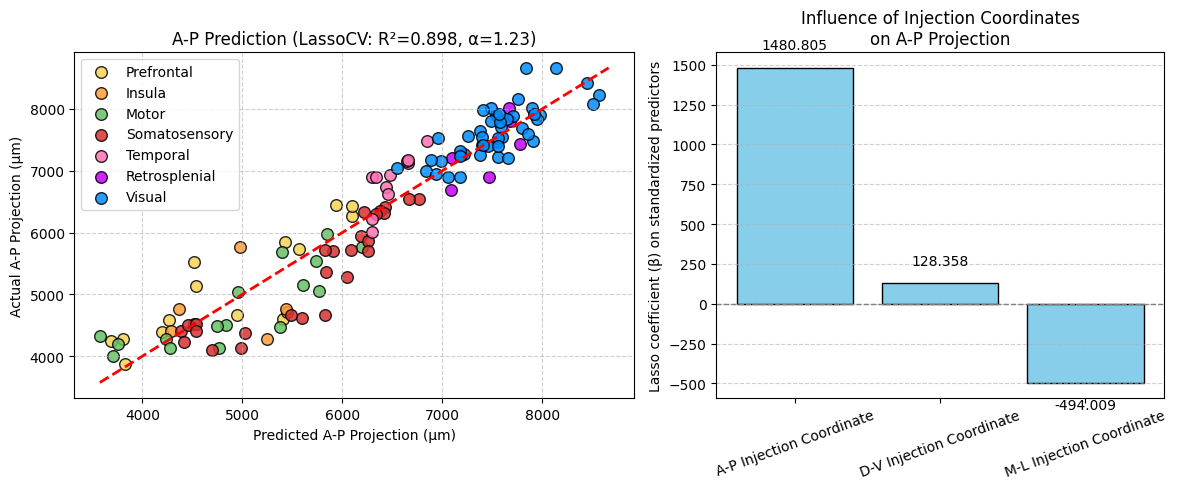

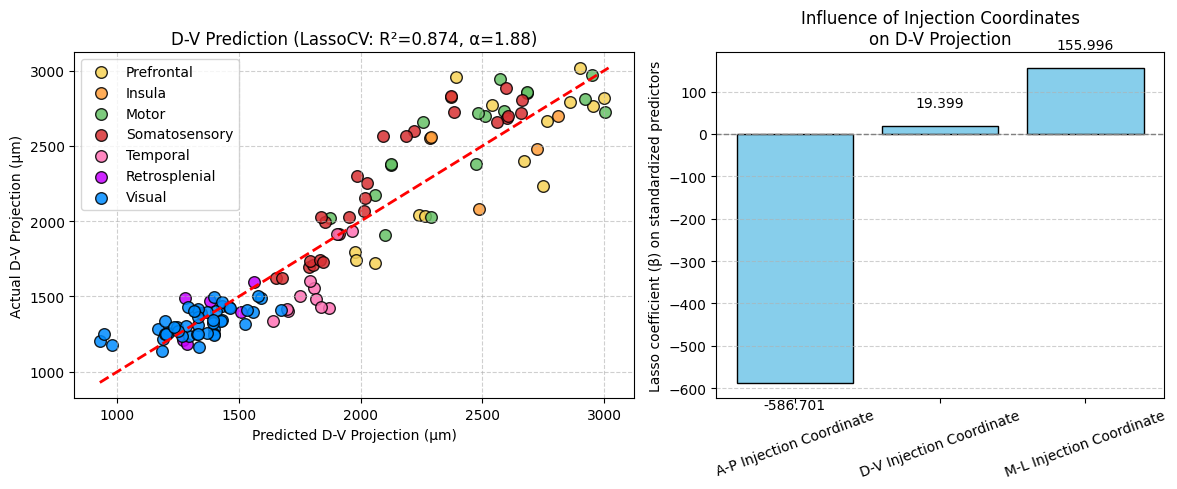

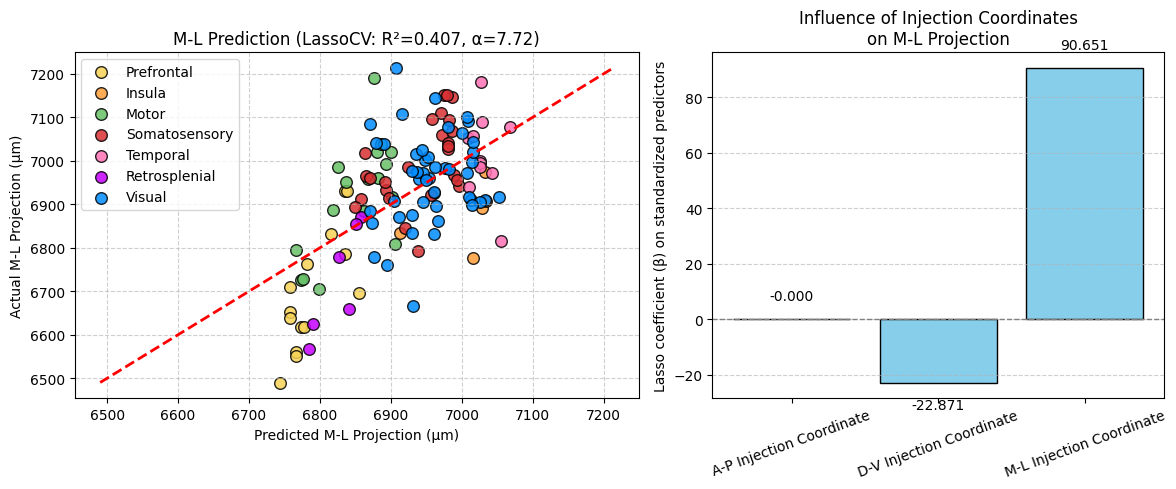

In [80]:
# Fit lasso models
lasso_models = fit_lasso_models(df_regions, cv=5)

# Plot per axis
plot_axis_summary_lasso(lasso_models, df_regions, group_color_hex, legend_order, axis_key='x')  # A-P
plot_axis_summary_lasso(lasso_models, df_regions, group_color_hex, legend_order, axis_key='y')  # D-V
plot_axis_summary_lasso(lasso_models, df_regions, group_color_hex, legend_order, axis_key='z')  # M-L

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def maxip_views_atlas_style(rgb_stack, boost=1.5):
    """
    Assumes rgb_stack axes are (X, Y, Z, 3) = (A-P, D-V, M-L, RGB).

    Returns coronal, sagittal, axial with atlas-like upright orientation.
    """
    # coronal, collapse A-P
    coronal = np.max(rgb_stack, axis=0)         
    #coronal = np.rot90(coronal, k=1)            
    #coronal = np.flipud(coronal)              
    coronal = np.clip(coronal * boost, 0, 1)

    # saggital, collapse M-L
    sagittal = np.max(rgb_stack, axis=2)        
    sagittal = np.rot90(sagittal, k=1)          
    sagittal = np.flipud(sagittal)             
    sagittal = np.clip(sagittal * boost, 0, 1)

    # axial, collapse D-V
    axial = np.max(rgb_stack, axis=1) # (A-P, M-L, 3)
    axial = np.rot90(axial, k=1)  
    #axial = np.fliplr(axial)                   
    axial = np.clip(axial * boost, 0, 1)

    return coronal, sagittal, axial

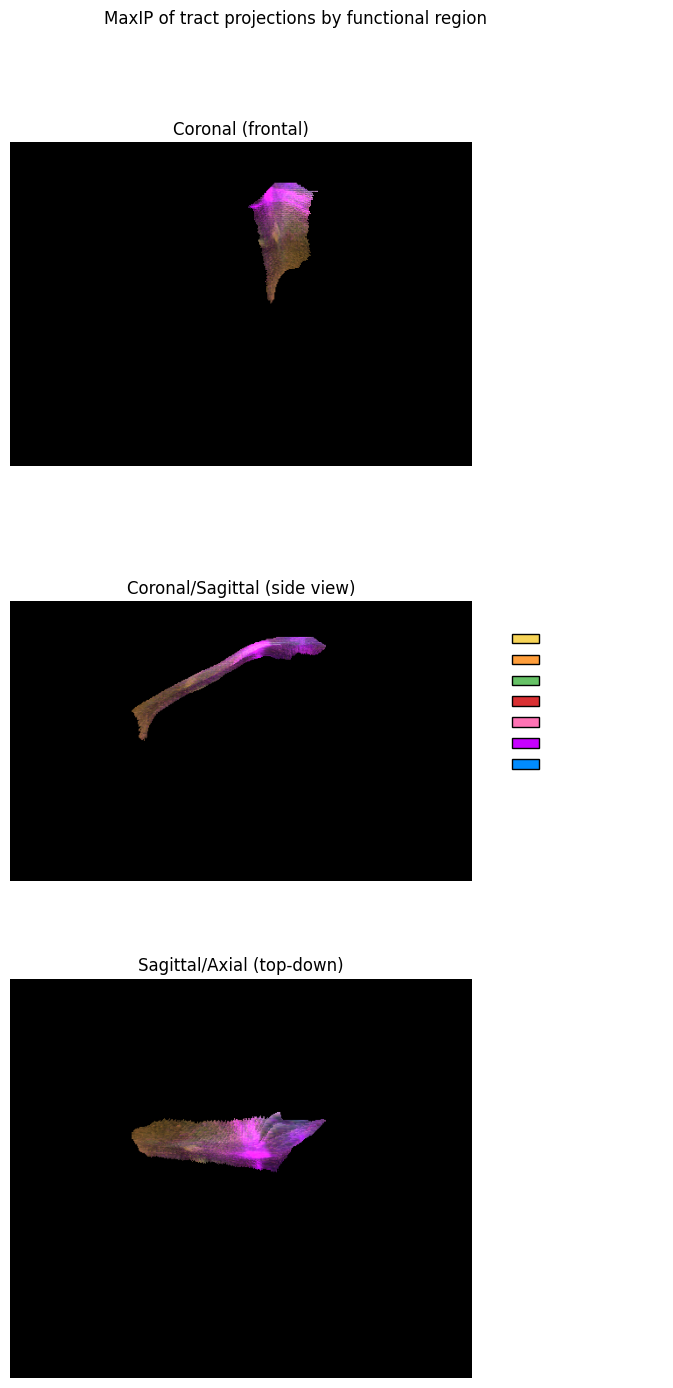

In [83]:
def plot_three_views_atlas_style(
    rgb_stack,
    title="MaxIP of tract projections by functional region",
    boost=1.5,
    out_svg="three_views_atlas.svg",
    out_eps="three_views_atlas.eps",
):
    coronal, sagittal, axial = maxip_views_atlas_style(rgb_stack, boost=boost)

    legend_patches = [
        Patch(facecolor=region_colors[g]["color"], edgecolor="black", label=g)
        for g in legend_order if g in region_colors
    ]

    fig, axs = plt.subplots(3, 1, figsize=(6, 14))

    axs[0].imshow(coronal)
    axs[0].set_title("Coronal (frontal)")
    axs[0].axis("off")

    axs[1].imshow(sagittal)
    axs[1].set_title("Coronal/Sagittal (side view)")
    axs[1].axis("off")

    axs[2].imshow(axial)
    axs[2].set_title("Sagittal/Axial (top-down)")
    axs[2].axis("off")

    plt.tight_layout(rect=[0, 0, 0.82, 0.96])

    leg = fig.legend(
        handles=legend_patches,
        loc="center left",
        bbox_to_anchor=(0.84, 0.5),
        frameon=False,
    )
    for t in leg.get_texts():
        t.set_color("white")

    fig.suptitle(title, y=0.995)

    fig.savefig(out_svg, format="svg", dpi=300, bbox_inches="tight")
    fig.savefig(out_eps, format="eps", dpi=300, bbox_inches="tight")
    plt.show()


plot_three_views_atlas_style(rgb_stack, boost=1.5)

In [76]:
try:
    ccf, _ = mcc.get_template_volume()
except Exception:
    ccf = None
    print("[!] Could not load template volume. Set `ccf` manually to use overlays.")

from ipywidgets import interact, FloatSlider
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


def plot_ccf_projection_overlay_interactive_raw(
    x_um,
    red_boost=1.0,
    green_boost=1.0,
    blue_boost=1.0,
    alpha=0.7,
):
    if ccf is None:
        print("[!] No template volume loaded (ccf is None).")
        return

    x_vox = int(x_um / voxel_size_um)
    if x_vox < 0 or x_vox >= ccf.shape[0]:
        print(f"[!] Invalid slice index {x_vox}")
        return

    # anatomy
    ccf_slice = ccf[x_vox, :, :]
    anatomy = (ccf_slice - ccf_slice.min()) / (ccf_slice.ptp() if ccf_slice.ptp() > 0 else 1)

    # RGB
    rgb = rgb_stack[x_vox, :, :, :].copy()
    rgb[..., 0] = np.clip(rgb[..., 0] * red_boost,   0, 1)
    rgb[..., 1] = np.clip(rgb[..., 1] * green_boost, 0, 1)
    rgb[..., 2] = np.clip(rgb[..., 2] * blue_boost,  0, 1)

    # plot
    fig, ax = plt.subplots(figsize=(9, 9))
    ax.imshow(anatomy, cmap="gray")              
    ax.imshow(rgb, alpha=alpha)                  
    ax.set_title(f"Coronal slice at {x_um:.0f} µm: projections over CCF anatomy")
    ax.axis("off")

    handles = [
        Patch(facecolor=region_colors[g]["color"], edgecolor="black", label=g)
        for g in legend_order if g in region_colors
    ]
    ax.legend(handles=handles, title="Injection region", loc="lower left",
              frameon=True, fontsize=10, title_fontsize=11)

    plt.tight_layout()
    plt.show()


interact(
    plot_ccf_projection_overlay_interactive_raw,
    x_um=FloatSlider(min=3000, max=10000, step=100, value=6200, description="A-P (µm)"),
    red_boost=FloatSlider(min=0.5, max=3.0, step=0.1, value=1.5, description="Red"),
    green_boost=FloatSlider(min=0.5, max=3.0, step=0.1, value=1.0, description="Green"),
    blue_boost=FloatSlider(min=0.5, max=3.0, step=0.1, value=1.5, description="Blue"),
    alpha=FloatSlider(min=0.2, max=1.0, step=0.05, value=0.7, description="Overlay α"),
)


interactive(children=(FloatSlider(value=6200.0, description='A-P (µm)', max=10000.0, min=3000.0, step=100.0), …

<function __main__.plot_ccf_projection_overlay_interactive_raw(x_um, red_boost=1.0, green_boost=1.0, blue_boost=1.0, alpha=0.7)>